# Introduction to machine learning & Data Analysis

Basic introduction on how to perform typical machine learning tasks with Python.

Prepared by Mykhailo Vladymyrov,
Data Science Lab, University Of Bern, 2023

This work is licensed under <a href="https://creativecommons.org/share-your-work/public-domain/cc0/">CC0</a>.

# Solutions 

# Load libs

In [1]:
# Scikit-learn (formerly scikits.learn and also known as sklearn) is a free 
# software machine learning library for the Python programming language. 
# It features various classification, regression and clustering algorithms, 
# and is designed to interoperate with the Python numerical and scientific 
# libraries NumPy and SciPy. (from wiki)

from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# common visualization module
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns
sns.set()

# numeric library
import numpy as np

import os
import pandas as pd
from time import time as timer
import tarfile

import tensorflow as tf
from scipy.stats import entropy


%matplotlib inline
from matplotlib import animation
from IPython.display import HTML
from IPython.display import SVG


In [2]:
if not os.path.exists('data'):
    path = os.path.abspath('.')+'/colab_material.tgz'
    tf.keras.utils.get_file(path, 'https://raw.githubusercontent.com/dsl-unibe-ch/ML_with_scikit-learn/main/colab_material.tgz')
    tar = tarfile.open(path, "r:gz")
    tar.extractall()
    tar.close()

506782/506782 [==============================] - 0s 0us/step


In [3]:
from utils.routines import *

In [4]:
pip install dtreeviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.5/91.5 kB 4.9 MB/s eta 0:00:00


In [5]:
pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82816 sha256=17259ae040848d3c4f17c2f089968130174f6443822a47b39cc5753de082bf0f
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55622 sha256=71c457630a8c5e3707f3cf87e673c25fc803dd5bc89159996c1c2d9818abce93
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


In [6]:
import dtreeviz # remember to load the package
import umap

In this course we will use several synthetic and real-world datasets to ilustrate the behavior of the models and excercise our skills.

# Datasets

In this course we will use several synthetic and real-world datasets to illustrate the behavior of the models and exercise our skills.

## 1. Synthetic linear

In [7]:
def get_linear(n_d=1, n_points=10, w=None, b=None, sigma=5):
  x = np.random.uniform(0, 10, size=(n_points, n_d))
  
  w = w or np.random.uniform(0.1, 10, n_d)
  b = b or np.random.uniform(-10, 10)
  y = np.dot(x, w) + b + np.random.normal(0, sigma, size=n_points)

  print('true slopes: w =', w, ';  b =', b)

  return x, y

true slopes: w = [6.20448881] ;  b = 2.6954639321806884


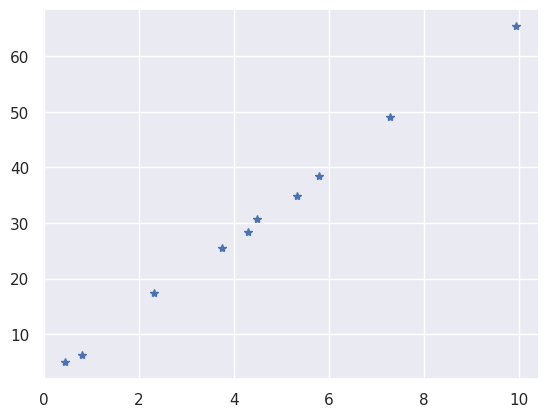

In [8]:
x, y = get_linear(n_d=1, sigma=1)
plt.plot(x[:, 0], y, '*')
plt.show()

true slopes: w = [4.04173717 3.14866107] ;  b = 3.0618173228184116


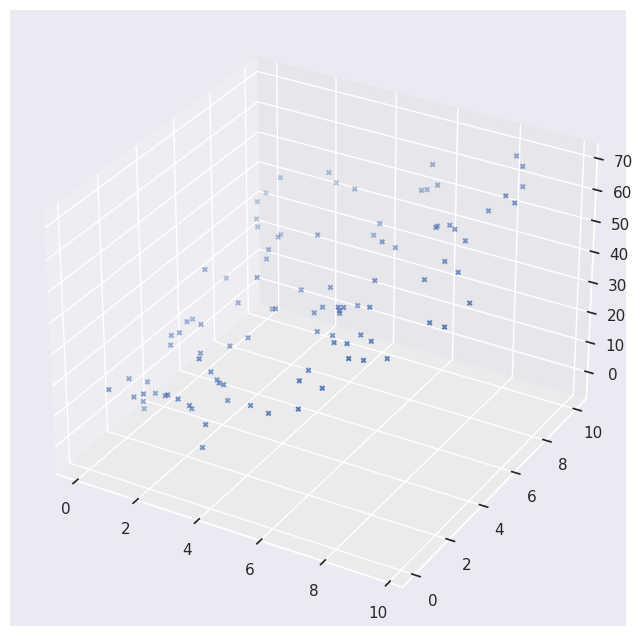

In [9]:
n_d = 2
x, y = get_linear(n_d=n_d, n_points=100)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:,0], x[:,1], y, marker='x', color='b',s=10)
plt.show()

## 2. House prices

Subset of the Ames Houses dataset: http://jse.amstat.org/v19n3/decock.pdf

In [10]:
def house_prices_dataset(return_df=False, return_df_xy=False, use_dummies=False, price_max=400000, area_max=40000):
  path = 'data/AmesHousing.csv'

  df = pd.read_csv(path, na_values=('NaN', ''), keep_default_na=False,  )
  
  rename_dict = {k:k.replace(' ', '').replace('/', '') for k in df.keys()}
  df.rename(columns=rename_dict, inplace=True)
  
  useful_fields = ['LotArea',
                  'Utilities', 'OverallQual', 'OverallCond',
                  'YearBuilt', 'YearRemodAdd', 'ExterQual', 'ExterCond',
                  'HeatingQC', 'CentralAir', 'Electrical',
                  '1stFlrSF', '2ndFlrSF','GrLivArea',
                  'FullBath', 'HalfBath',
                  'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
                  'Functional','PoolArea',
                  'YrSold', 'MoSold'
                  ]
  target_field = 'SalePrice'

  df.dropna(axis=0, subset=useful_fields+[target_field], inplace=True)

  cleanup_nums = {'Street':      {'Grvl': 0, 'Pave': 1},
                  'LotFrontage': {'NA':0},
                  'Alley':       {'NA':0, 'Grvl': 1, 'Pave': 2},
                  'LotShape':    {'IR3':0, 'IR2': 1, 'IR1': 2, 'Reg':3},
                  'Utilities':   {'ELO':0, 'NoSeWa': 1, 'NoSewr': 2, 'AllPub': 3},
                  'LandSlope':   {'Sev':0, 'Mod': 1, 'Gtl': 3},
                  'ExterQual':   {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'ExterCond':   {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'BsmtQual':    {'NA':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
                  'BsmtCond':    {'NA':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
                  'BsmtExposure':{'NA':0, 'No':1, 'Mn': 2, 'Av': 3, 'Gd': 4},
                  'BsmtFinType1':{'NA':0, 'Unf':1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ':5, 'GLQ':6},
                  'BsmtFinType2':{'NA':0, 'Unf':1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ':5, 'GLQ':6},
                  'HeatingQC':   {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'CentralAir':  {'N':0, 'Y': 1},
                  'Electrical':  {'':0, 'NA':0, 'Mix':1, 'FuseP':2, 'FuseF': 3, 'FuseA': 4, 'SBrkr': 5},
                  'KitchenQual': {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'Functional':  {'Sal':0, 'Sev':1, 'Maj2': 2, 'Maj1': 3, 'Mod': 4, 'Min2':5, 'Min1':6, 'Typ':7},
                  'FireplaceQu': {'NA':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
                  'PoolQC':      {'NA':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'Fence':       {'NA':0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv':4},
                  }

  df_X = df[useful_fields].copy()                              
  if use_dummies:
    cols = [k for k in cleanup_nums.keys() if k in useful_fields]
    df_X = pd.get_dummies(df_X, columns=cols)  # the categorical variables will be changed to one-hot encoding
  else:
    df_X.replace(cleanup_nums, inplace=True)  # convert continous categorial variables to numerical. Applicable only to 

  df_Y = df[target_field].copy()

  x = df_X.to_numpy().astype(np.float32)
  y = df_Y.to_numpy().astype(np.float32)

  if price_max>0:
    idxs = y<price_max
    x = x[idxs]
    y = y[idxs]

  if area_max>0:
    idxs = x[:,0]<area_max
    x = x[idxs]
    y = y[idxs]

  return (x, y, df) if return_df else ((x, y, (df_X, df_Y)) if return_df_xy else (x,y))

In [11]:
# x, y, (df_X, df_Y) = house_prices_dataset(return_df_xy=True, use_dummies=True)
# print(x.shape, y.shape)
# df_X.head()

In [12]:
# df_X.describe()

In [13]:
x, y, (df_X, df_Y) = house_prices_dataset(return_df_xy=True, use_dummies=False)
print(x.shape, y.shape)
df_X.head()

(2847, 24) (2847,)


LotArea  Utilities  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0    31770          3            6            5       1960          1960   
1    11622          3            5            6       1961          1961   
2    14267          3            6            6       1958          1958   
3    11160          3            7            5       1968          1968   
4    13830          3            5            5       1997          1998   

   ExterQual  ExterCond  HeatingQC  CentralAir  ...  FullBath  HalfBath  \
0          2          2          1           1  ...         1         0   
1          2          2          2           1  ...         1         0   
2          2          2          2           1  ...         1         1   
3          3          2          4           1  ...         2         1   
4          2          2          3           1  ...         2         1   

   BedroomAbvGr  KitchenAbvGr  KitchenQual  TotRmsAbvGrd  Functional  \
0             3             1            2             7           7   
1             2             1            2             5           7   
2             3             1            3             6           7   
3             3             1            4             8           7   
4             3             1            2             6           7   

   PoolArea  YrSold  MoSold  
0         0    2010       5  
1         0    2010       6  
2         0    2010       6  
3         0    2010       4  
4         0    2010       3  

[5 rows x 24 columns]

In [14]:
df_X.describe()

LotArea    Utilities  OverallQual  OverallCond    YearBuilt  \
count    2929.00000  2929.000000  2929.000000  2929.000000  2929.000000   
mean    10148.06282     2.998634     6.095254     5.563332  1971.344486   
std      7881.35958     0.045247     1.411122     1.111678    30.243747   
min      1300.00000     1.000000     1.000000     1.000000  1872.000000   
25%      7440.00000     3.000000     5.000000     5.000000  1954.000000   
50%      9434.00000     3.000000     6.000000     5.000000  1973.000000   
75%     11556.00000     3.000000     7.000000     6.000000  2001.000000   
max    215245.00000     3.000000    10.000000     9.000000  2010.000000   

       YearRemodAdd    ExterQual    ExterCond    HeatingQC   CentralAir  ...  \
count   2929.000000  2929.000000  2929.000000  2929.000000  2929.000000  ...   
mean    1984.258791     2.398771     2.085353     3.149539     0.933083  ...   
std       20.859616     0.580370     0.371758     0.958230     0.249921  ...   
min     1950.000000     1.000000     0.000000     0.000000     0.000000  ...   
25%     1965.000000     2.000000     2.000000     2.000000     1.000000  ...   
50%     1993.000000     2.000000     2.000000     4.000000     1.000000  ...   
75%     2004.000000     3.000000     2.000000     4.000000     1.000000  ...   
max     2010.000000     4.000000     4.000000     4.000000     1.000000  ...   

          FullBath     HalfBath  BedroomAbvGr  KitchenAbvGr  KitchenQual  \
count  2929.000000  2929.000000   2929.000000   2929.000000  2929.000000   
mean      1.566405     0.379310      2.854216      1.044384     2.511096   
std       0.552977     0.502584      0.827868      0.214111     0.663214   
min       0.000000     0.000000      0.000000      0.000000     0.000000   
25%       1.000000     0.000000      2.000000      1.000000     2.000000   
50%       2.000000     0.000000      3.000000      1.000000     2.000000   
75%       2.000000     1.000000      3.000000      1.000000     3.000000   
max       4.000000     2.000000      8.000000      3.000000     4.000000   

       TotRmsAbvGrd   Functional     PoolArea       YrSold       MoSold  
count   2929.000000  2929.000000  2929.000000  2929.000000  2929.000000  
mean       6.442813     6.843974     2.244111  2007.790372     6.216456  
std        1.573199     0.663164    35.603235     1.316832     2.714863  
min        2.000000     0.000000     0.000000  2006.000000     1.000000  
25%        5.000000     7.000000     0.000000  2007.000000     4.000000  
50%        6.000000     7.000000     0.000000  2008.000000     6.000000  
75%        7.000000     7.000000     0.000000  2009.000000     8.000000  
max       15.000000     7.000000   800.000000  2010.000000    12.000000  

[8 rows x 24 columns]

In [15]:
df_Y.describe()

count      2929.000000
mean     180800.599522
std       79899.955086
min       12789.000000
25%      129500.000000
50%      160000.000000
75%      213500.000000
max      755000.000000
Name: SalePrice, dtype: float64

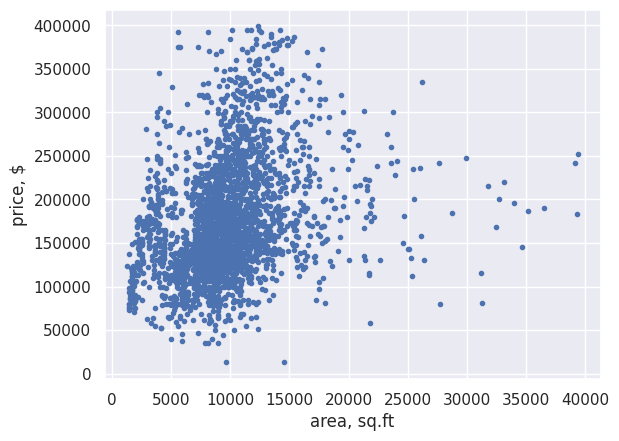

In [16]:
plt.plot(x[:, 0], y, '.')
plt.xlabel('area, sq.ft')
plt.ylabel('price, $');
plt.show()

## 3. Blobs

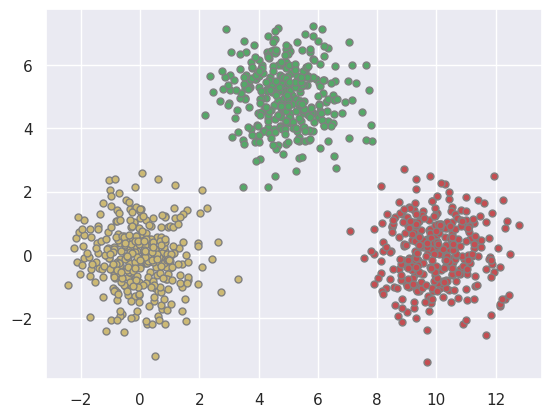

In [17]:
x, y = make_blobs(n_samples=1000, centers=[[0,0], [5,5], [10, 0]])
colors = "ygr"
for i, color in enumerate(colors):
    idx = y == i
    plt.scatter(x[idx, 0], x[idx, 1], c=color, edgecolor='gray', s=25)
plt.show()

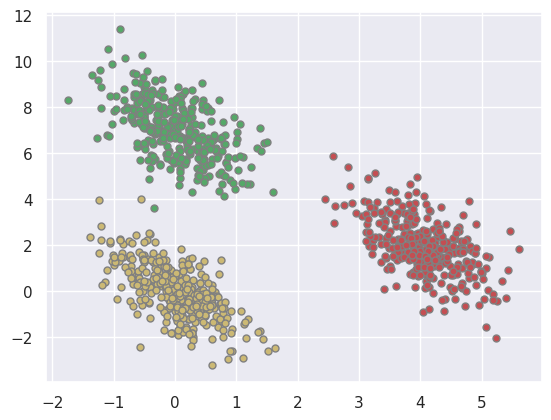

In [18]:
x, y = make_blobs(n_samples=1000, centers=[[0,0], [5,5], [10, 0]])

transformation = [[0.4, 0.2], [-0.4, 1.2]]  # affine transformation matrix
x = np.dot(x, transformation)               # applied to point coordinated to make blobs less separable

colors = "ygr"
for i, color in enumerate(colors):
    idx = y == i
    plt.scatter(x[idx, 0], x[idx, 1], c=color, edgecolor='gray', s=25)
plt.show()



## 4. Fashion MNIST

`Fashion-MNIST` is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. (from https://github.com/zalandoresearch/fashion-mnist)

In [19]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [20]:
fmnist_class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Each of the training and test examples is assigned to one of the following labels:

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

Let's check few samples:

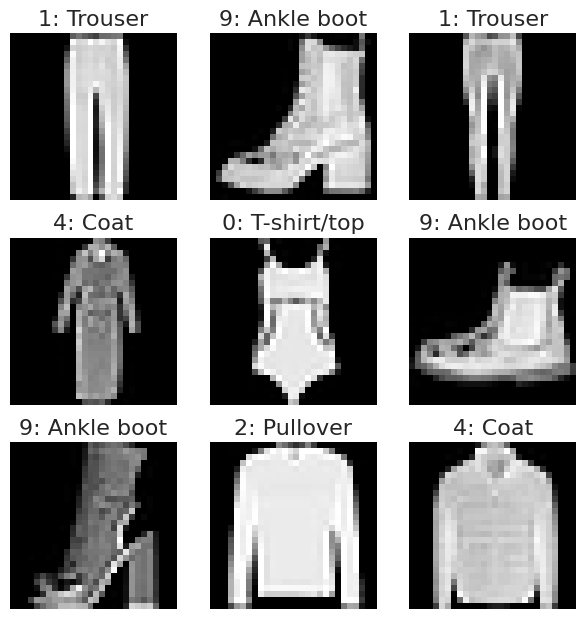

In [21]:
n = 3
fig, ax = plt.subplots(n, n, figsize=(2*n, 2*n))
ax = [ax_xy for ax_y in ax for ax_xy in ax_y]
for axi, im_idx in zip(ax, np.random.choice(len(train_images), n**2)):
  im = train_images[im_idx]
  im_class = train_labels[im_idx]
  axi.imshow(im, cmap='gray')
  axi.set_title(f'{im_class}: {fmnist_class_names[im_class]}', size=16)
  axi.grid(False)
  axi.axis('off')
plt.tight_layout(pad=0,h_pad=0.8,w_pad=0)
plt.show()

## 5. Weather dataset

This is a weather time series [dataset](https://www.bgc-jena.mpg.de/wetter/) recorded by the Max Planck Institute for Biogeochemistry 
It contains weather reacord for 8 years of observation.

In [22]:
def get_weather_df():
  # inspired by https://www.tensorflow.org/tutorials/structured_data/time_series

  # download and extract dataset
  zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
  csv_path, _ = os.path.splitext(zip_path)

  # load into pandas df
  df = pd.read_csv(csv_path)
  
  # dataset contains records every 10 min, we use hourly records only, thus
  # slice [start:stop:step], starting from index 5 take every 6th record
  df = df[5::6]

  # replace errors in wind velocity to 0
  wv = df['wv (m/s)']
  bad_wv = wv == -9999.0
  wv[bad_wv] = 0.0

  max_wv = df['max. wv (m/s)']
  bad_max_wv = max_wv == -9999.0
  max_wv[bad_max_wv] = 0.0

  # obtain timestamps from text time format
  date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
  timestamp_s = date_time.map(pd.Timestamp.timestamp)
  # genarate cyclic features for year and day
  day = 24*60*60
  year = (365.2425) * day

  df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
  df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
  df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
  df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

  return df

In [23]:
weather_df = get_weather_df()

13568290/13568290 [==============================] - 0s 0us/step


In [24]:
weather_df.head()

p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  VPmax (mbar)  \
5     996.50     -8.05    265.38        -8.78    94.4          3.33   
11    996.62     -8.88    264.54        -9.77    93.2          3.12   
17    996.84     -8.81    264.59        -9.66    93.5          3.13   
23    996.99     -9.05    264.34       -10.02    92.6          3.07   
29    997.46     -9.63    263.72       -10.65    92.2          2.94   

    VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  rho (g/m**3)  \
5           3.14          0.19       1.96             3.15       1307.86   
11          2.90          0.21       1.81             2.91       1312.25   
17          2.93          0.20       1.83             2.94       1312.18   
23          2.85          0.23       1.78             2.85       1313.61   
29          2.71          0.23       1.69             2.71       1317.19   

    wv (m/s)  max. wv (m/s)  wd (deg)   Day sin   Day cos  Year sin  Year cos  
5       0.21           0.63     192.7  0.258819  0.965926  0.010049  0.999950  
11      0.25           0.63     190.3  0.500000  0.866025  0.010766  0.999942  
17      0.18           0.63     167.2  0.707107  0.707107  0.011483  0.999934  
23      0.10           0.38     240.0  0.866025  0.500000  0.012199  0.999926  
29      0.40           0.88     157.0  0.965926  0.258819  0.012916  0.999917

In [25]:
weather_df.describe().T

count         mean        std      min          25%  \
p (mbar)         70091.0   989.212842   8.358886   913.60   984.200000   
T (degC)         70091.0     9.450482   8.423384   -22.76     3.350000   
Tpot (K)         70091.0   283.493086   8.504424   250.85   277.440000   
Tdew (degC)      70091.0     4.956471   6.730081   -24.80     0.240000   
rh (%)           70091.0    76.009788  16.474920    13.88    65.210000   
VPmax (mbar)     70091.0    13.576576   7.739883     0.97     7.770000   
VPact (mbar)     70091.0     9.533968   4.183658     0.81     6.220000   
VPdef (mbar)     70091.0     4.042536   4.898549     0.00     0.870000   
sh (g/kg)        70091.0     6.022560   2.655812     0.51     3.920000   
H2OC (mmol/mol)  70091.0     9.640437   4.234862     0.81     6.290000   
rho (g/m**3)     70091.0  1216.061232  39.974263  1059.45  1187.470000   
wv (m/s)         70091.0     2.130539   1.543098     0.00     0.990000   
max. wv (m/s)    70091.0     3.533671   2.343417     0.00     1.760000   
wd (deg)         70091.0   174.789095  86.619431     0.00   125.300000   
Day sin          70091.0    -0.000061   0.707099    -1.00    -0.707107   
Day cos          70091.0    -0.000143   0.707124    -1.00    -0.707107   
Year sin         70091.0     0.001614   0.706813    -1.00    -0.704504   
Year cos         70091.0    -0.000672   0.707408    -1.00    -0.708115   

                          50%          75%      max  
p (mbar)         9.895700e+02   994.720000  1015.29  
T (degC)         9.410000e+00    15.480000    37.28  
Tpot (K)         2.834600e+02   289.530000   311.21  
Tdew (degC)      5.210000e+00    10.080000    23.06  
rh (%)           7.930000e+01    89.400000   100.00  
VPmax (mbar)     1.182000e+01    17.610000    63.77  
VPact (mbar)     8.860000e+00    12.360000    28.25  
VPdef (mbar)     2.190000e+00     5.300000    46.01  
sh (g/kg)        5.590000e+00     7.800000    18.07  
H2OC (mmol/mol)  8.960000e+00    12.490000    28.74  
rho (g/m**3)     1.213800e+03  1242.765000  1393.54  
wv (m/s)         1.760000e+00     2.860000    14.01  
max. wv (m/s)    2.980000e+00     4.740000    23.50  
wd (deg)         1.981000e+02   234.000000   360.00  
Day sin          1.321740e-14     0.707107     1.00  
Day cos         -9.732065e-15     0.707107     1.00  
Year sin         3.316307e-03     0.708301     1.00  
Year cos        -1.121764e-03     0.707423     1.00

In [26]:
# plt.plot(weather_df['Year cos'])
# plt.plot(weather_df['Year sin'])

In [27]:
# plt.plot(weather_df['Day cos'][:7*24])
# plt.plot(weather_df['Day sin'][:7*24])

In [28]:
def gen_future_T_dataset(X_len=24, Y_offset=48,
                         X_features=['p (mbar)', 'T (degC)', 'rh (%)', 'wv (m/s)', 'wd (deg)', 'Day sin', 'Day cos', 'Year sin', 'Year cos'],
                         Y_features='T (degC)',
                         standardize=True,
                         oversample=10
                         ):
  """
  Generates pairs of input-label, using sequence of `X_len` samples as input
  and value at offset `Y_offset` from start of this sequence as label.
  Sample sequnces arte taken at random positions throughout the dataset.
  Number of samples is obtained assuming non-overlaping wondows.
  Oversampling factor allows to increase this value.

  Args:
    X_len (int): length of sample sequence
    Y_offset (int): offset to the target value from the sequence start
    X_features (list or str): features to be used as input
    Y_features (list or str): features to be used as labels
    standardize (Bool): flag whether to standardize the columns
    oversample (int): increases number of samples by this factor wrt baseline
                      n = len(df) // (Y_offset+1)
  """
  weather_df = get_weather_df()

  if standardize:
    mean = weather_df.mean()
    std = weather_df.std()
    weather_df = (weather_df - mean) / std
  
  df_X = weather_df[X_features]
  df_Y = weather_df[Y_features]

  n_records = len(df_X)
  sample_len = Y_offset+1
  n_samples = int((n_records-sample_len)//sample_len*oversample)
  offsets = np.random.randint(0, n_records-sample_len, size=n_samples)
  offsets.sort()

  X = []
  Y = []
  for o in offsets:
    X.append(np.array(df_X[o:o+X_len]))
    Y.append(np.array(df_Y[o+Y_offset:o+Y_offset+1]))

  X = np.stack(X)
  Y = np.concatenate(Y)

  return X, Y

In [29]:
x, y = gen_future_T_dataset()

In [30]:
x.shape, y.shape

((14290, 24, 9), (14290,))

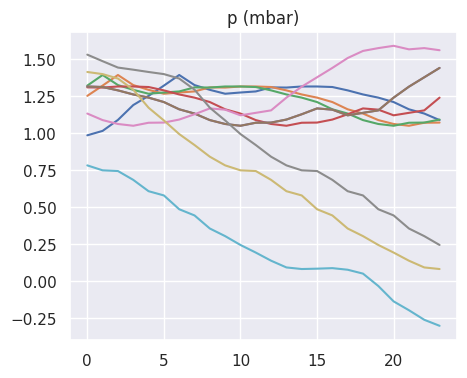

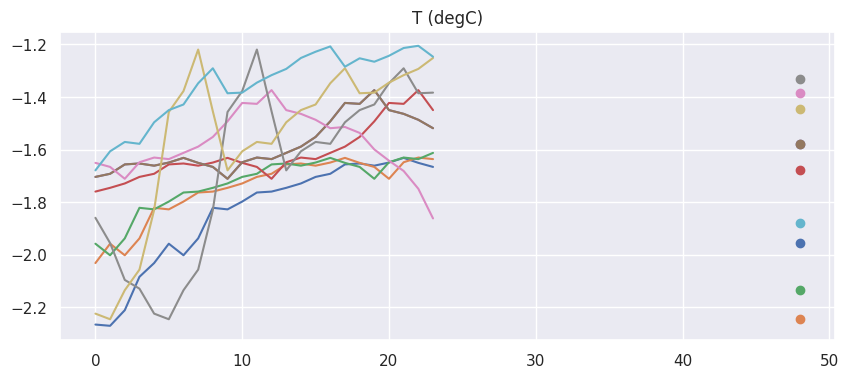

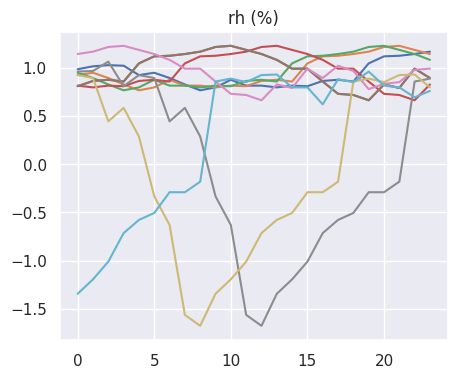

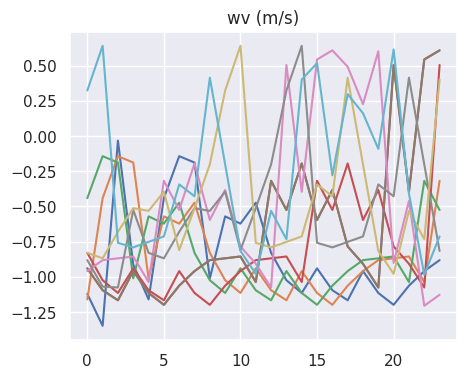

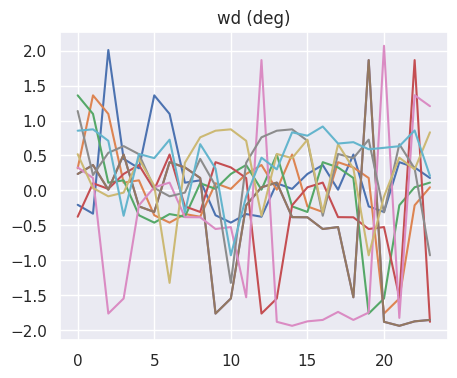

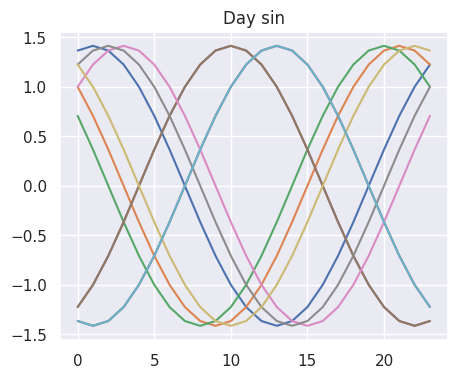

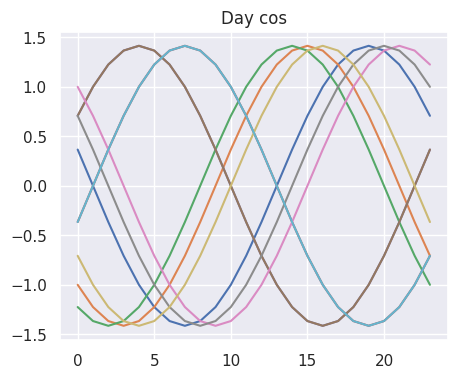

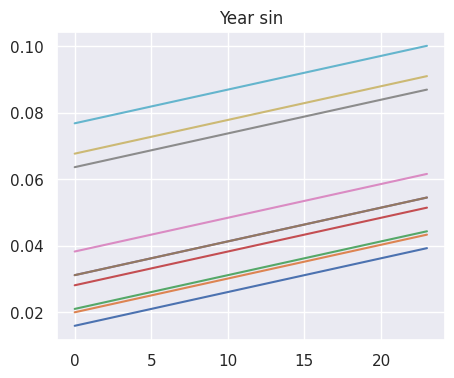

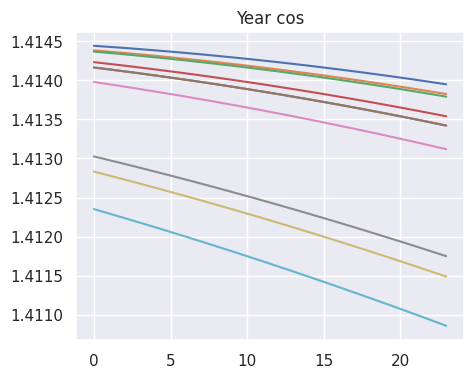

In [31]:
for f,fn in enumerate(['p (mbar)', 'T (degC)', 'rh (%)', 'wv (m/s)', 'wd (deg)', 'Day sin', 'Day cos', 'Year sin', 'Year cos']):
  plt.figure(figsize=(5*(1+(f==1)), 4))
  for s in range(10):
    plt.plot(x[s, :, f])
    if f==1:
      plt.scatter(48, y[s], color=plt.gca().lines[-1].get_color())
  plt.title(fn)
  plt.show()

# 1.Regression and Classification

## EXERCISE 1.

train mse = 26383.736
test mse = 24962.984
train mae = 18237.145
test mae = 18405.145
train R2 = 0.8365341246803327
test R2 = 0.8680051338083284


[]

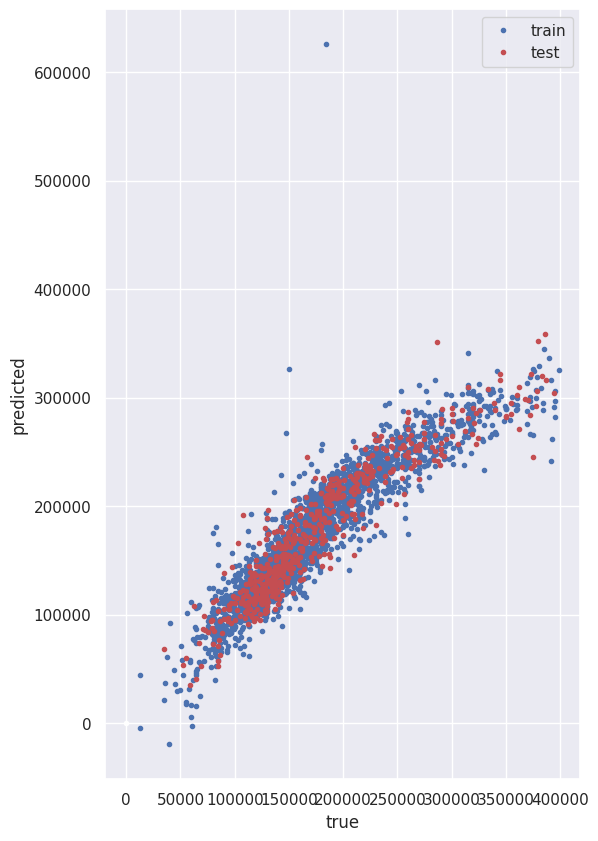

In [32]:
# Solution:
x, y = house_prices_dataset()

# 1. make train/test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# 2. fit the model
reg = linear_model.LinearRegression()
reg.fit(x_train, y_train)

# 3. evaluate MSE, MAD, and R2 on train and test datasets
#prediction:
y_p_train = reg.predict(x_train)
y_p_test = reg.predict(x_test)

# mse
print('train mse =', np.std(y_train - y_p_train))
print('test mse =', np.std(y_test - y_p_test))
# mse
print('train mae =', np.mean(np.abs(y_train - y_p_train)))
print('test mae =', np.mean(np.abs(y_test - y_p_test)))
# R2
print('train R2 =', reg.score(x_train, y_train))
print('test R2 =', reg.score(x_test, y_test))

# 4. plot y vs predicted y for test and train parts
plt.figure(figsize=(10,10))
plt.plot(y_train, y_p_train, 'b.', label='train')
plt.plot(y_test, y_p_test, 'r.', label='test')

plt.plot([0], [0], 'w.')  # dummy to have origin
plt.xlabel('true')
plt.ylabel('predicted')
plt.gca().set_aspect('equal')
plt.legend()
plt.plot()

## EXERCISE 2.

In [33]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

We will reshape 2-d images to 1-d arrays for use in scikit-learn:

In [34]:
n_train = len(train_labels)
x_train = train_images.reshape((n_train, -1))
y_train = train_labels

n_test = len(test_labels)
x_test = test_images.reshape((n_test, -1))
y_test = test_labels

Now use a multinomial logistic regression classifier, and measure the accuracy:

In [35]:
#solution
# 1. Create classifier
multi_class = 'multinomial'
clf = linear_model.LogisticRegression(solver='sag', max_iter=20,
                                      multi_class=multi_class)

# 2. fit the model
t1 = timer()
clf.fit(x_train, y_train)
t2 = timer()
print ('training time: %.1fs'%(t2-t1))

# 3. evaluate accuracy on train and test datasets
print("training score : %.3f" % (clf.score(x_train, y_train)))
print("test score : %.3f" % (clf.score(x_test, y_test)))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


training time: 92.6s
training score : 0.874
test score : 0.843


## EXERCISE 3 : Random forest classifier for FMNIST


In [36]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

n = len(train_labels)
x_train = train_images.reshape((n, -1))
y_train = train_labels

n_test = len(test_labels)
x_test = test_images.reshape((n_test, -1))
y_test = test_labels

In [37]:
# 1. Create classifier. As the number of features is big, use bigger tree depth 
# (max_depth parameter). in the same time to reduce variance, one should limit the
# total number of tree leafes. (max_leaf_nodes parameter)
# Try different number of estimators (n_estimators)

n_est = 20

dtc = ensemble.RandomForestClassifier(max_depth=700, n_estimators=n_est, max_leaf_nodes=500)

# 2. fit the model
t1 = timer()
dtc.fit(x_train, y_train)
t2 = timer()
print ('training time: %.1fs'%(t2-t1))

# 3. Inspect training and test accuracy
print("training score : %.3f (n_est=%d)" % (dtc.score(x_train, y_train), n_est))
print("test score : %.3f (n_est=%d)" % (dtc.score(x_test, y_test), n_est))


training time: 14.9s
training score : 0.893 (n_est=20)
test score : 0.855 (n_est=20)


## EXERCISE 4: Random forest regression


In [38]:
X, y, (df_x, df_y) = house_prices_dataset(return_df_xy=True)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Predict the house prices.

In [39]:
rfr = ensemble.RandomForestRegressor(max_depth=5, n_estimators=30)
rfr.fit(x_train, y_train)
rfr.score(x_test, y_test)

0.8264111032630468

In [40]:
viz_model = dtreeviz.model(rfr.estimators_[10],
                          X_train=x_train, y_train=y_train,
                          feature_names=list(df_x.keys())[:-1])

v = viz_model.view()     # render as SVG into internal object 

In [41]:
display(v)

In [42]:
rfr = ensemble.RandomForestRegressor(max_depth=30, n_estimators=70)
rfr.fit(x_train, y_train)
rfr.score(x_test, y_test)

0.8649862503032955

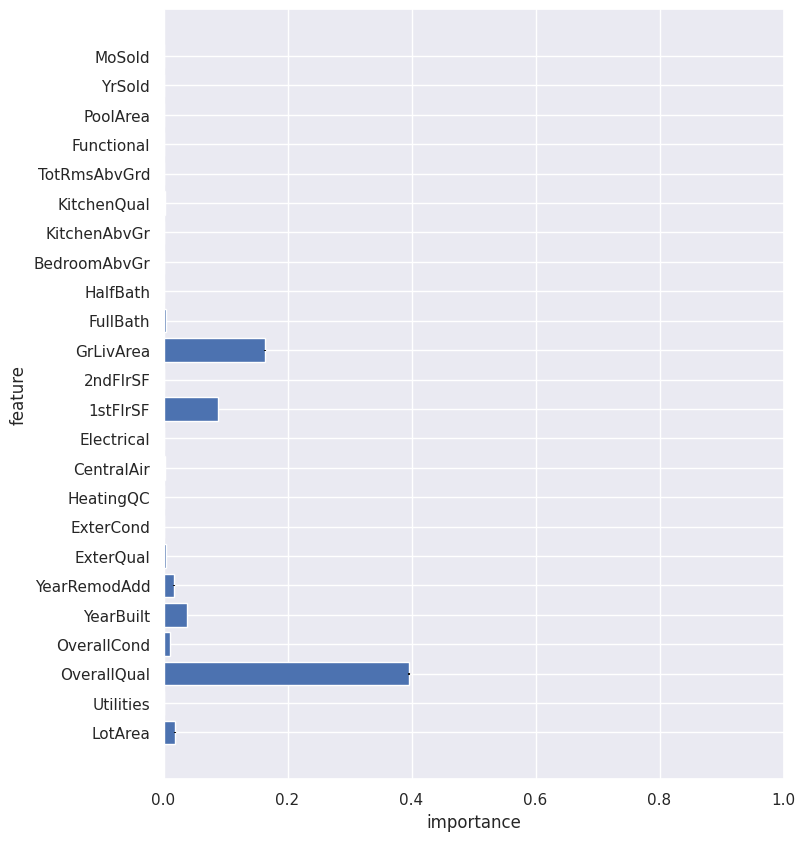

In [43]:
p_importances = permutation_importance(rfr, x_test, y_test, n_repeats=10, n_jobs=-1)

plt.figure(figsize=(8, 10))
plt.barh(list(df_x.columns),
        p_importances.importances_mean,
        yerr=p_importances.importances_std, )
plt.ylabel('feature')
plt.xlabel('importance')
plt.xlim(0, 1);

# 2. Clustering

## EXERCISE 1: Discover the number of Gaussians

(120, 5)
Number of clusters considered:  2


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


Number of clusters considered:  3


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


Number of clusters considered:  4
Number of clusters considered:  5
Number of clusters considered:  6
Number of clusters considered:  7


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


Number of clusters considered:  8


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


Number of clusters considered:  9


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


Number of clusters considered:  10


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


Number of clusters considered:  11
Number of clusters considered:  12


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


Number of clusters considered:  13
Number of clusters considered:  14


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


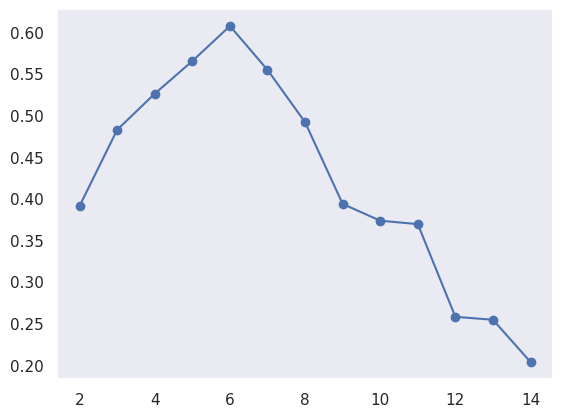

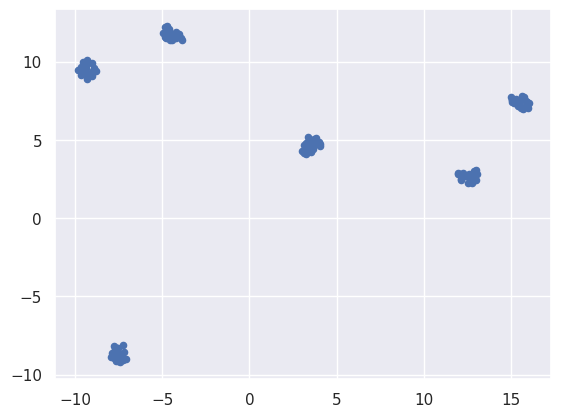

In [44]:
### In this exercise you are given the dataset points, consisting of high-dimensional data. It was built taking random 
#samples from a number k of multimensional gaussians. The data is therefore made of k clusters but, being 
#very high dimensional, you cannot visualize it. Your task it too use K-means combined with the Silouhette 
#score to find the number of k.

# 1. Load the data using the function load_ex1_data_clust() , check the dimensionality of the data.

points=load_ex1_data_clust()
print(points.shape)

# 2. Fix a number of clusters k and define a KMeans clusterer object. Perform the fitting and compute the Silhouette score. 
# Save the results on a list. 

plt.figure()
scores=[]
for itrial in range(2,15):
    print('Number of clusters considered: ',itrial)
    clusterer = KMeans(n_clusters=itrial, random_state=10)
    cluster_labels = clusterer.fit_predict(points)
    score=silhouette_score(points,cluster_labels)
    scores.append(score)

# 3. Plot the Silhouette scores as a function ok k? What is the number of clusters ?
plt.grid()
plt.plot(np.arange(len(scores))+2,np.array(scores),'-o')

# 4. Optional. Check the result that you found via umap. 
plt.figure()
umap_model = umap.UMAP(random_state=1711)
umap_gs = umap_model.fit_transform(points)
plt.scatter(umap_gs[:, 0], umap_gs [:, 1], s=20)

## EXERCISE 2: Predict the good using K-Means

In [45]:
# Follow the following STEPS to solve the exercise

# STEP 1. Load the dataset.

#fmnist = tf.keras.datasets.fashion_mnist
#(train_images, train_labels), (test_images, test_labels) = fmnist.load_data()

#X_train=train_images[:5000,:].reshape(5000,-1)
#y_train=train_labels[:5000]

#X_test=test_images[:1000,:].reshape(1000,-1)
#y_test=test_labels[:1000]

fmnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fmnist.load_data()

X_train=train_images[:5000,:].reshape(5000,-1)
y_train=train_labels[:5000]

X_test=test_images[:1000,:].reshape(1000,-1)
y_test=test_labels[:1000]

# STEP 2. 
# Define the cluster KMeans objecta and fit the model on the training set. 

clusterer = KMeans(n_clusters=10, random_state=10)
clusterer.fit(X_train)

# STEP 3. 
# Call the predict method of the KMeans object you defined on the training set and compute the cluster labels. 
# 
cluster_labels = clusterer.predict(X_train)

# STEP 4. 
# Use the function most_common with arguments (k,y_train, cluster_labels) to compute the assignement list. 
#  assignement[i] will be the majority class of the i-cluster  

def most_common(nclusters, supervised_labels, cluster_labels):
    
    """
    Args:
    - nclusters : the number of clusteres
    - supervised_labels : for each sample, the labelling provided by the training data ( e.g. in y_train or y_test)
    - cluster_labels : for each good, the cluster it was assigned by K-Means using the predict method of the Kmeans object
    
    Returns:
    - a list "assignement" of lengths nclusters, where assignement[i] is the majority class of the i-cluster 
    """
    
    assignement=[]
    for icluster in range(nclusters):
        indices=list(supervised_labels[cluster_labels==icluster])
        try:
            chosen= max(set(indices), key=indices.count)
        except ValueError :
            print('Em')
            chosen=1
        assignement.append(chosen)
        
    return assignement

assignement=most_common(10, y_train, cluster_labels)     

print(assignement)

# STEP 5. 
# Using the predict method of your KMeans object, predict the cluster labels for the test set using X_test as an argument.

### print('Training set')
### cluster_labels = clusterer.predict(X_train)
### new_labels=[assignement[i] for i in cluster_labels]
### cm=metrics.confusion_matrix( y_train, new_labels)
### print(np.sum([cm[i,i] for i in range(cm.shape[0])])/np.sum(cm))
### print(cm)

cluster_labels = clusterer.predict(X_test)

# STEP 6.
# using the cluster labels predicted in STEP 5 and the previously computed assignement[] list, 
# predict what are according to your model the predicted goods for the test set, call them new_labels
print()
print('Test set')

new_labels=[assignement[i] for i in cluster_labels]

# STEP 7.
# Using  a call cm=metrics.confusion_matrix( y_train, new_labels ) you can print the confusion matrix on the test set, which
# provides information on the quality of the fit. You can print the percentage of correctly classified examples 
# using the following lines:
#
# print(np.sum([cm[i,i] for i in range(cm.shape[0])])/np.sum(cm))
# print(cm)

cm=metrics.confusion_matrix( y_test, new_labels)
print(np.sum([cm[i,i] for i in range(cm.shape[0])])/np.sum(cm))
print(cm)

# STEP 8 (optional).
#  Perform again steps 2 / 3 increasing the number of clusters from 10 to 40 what happens to the performance ? 
for iclust in [10,20,30,40]:
    
        clusterer = KMeans(n_clusters=iclust, random_state=10)

        clusterer.fit(X_train)

        cluster_labels = clusterer.predict(X_train)
    
        assignement=most_common(iclust, y_train, cluster_labels)     

        print(assignement)
        
        print('Test set with '+str(iclust)+' clusters')

        cluster_labels = clusterer.predict(X_test)

        new_labels=[assignement[i] for i in cluster_labels]

        cm=metrics.confusion_matrix( y_test, new_labels)

        print(np.sum([cm[i,i] for i in range(cm.shape[0])])/np.sum(cm))
        print(cm)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


[7, 8, 6, 1, 8, 0, 9, 5, 9, 4]

Test set
0.549
[[62  3  0  0  7 10 25  0  0  0]
 [ 5 95  0  0  0  1  4  0  0  0]
 [ 2  0  0  0 68  7 33  0  1  0]
 [25 50  0  0  1  5 12  0  0  0]
 [20  3  0  0 73  2 17  0  0  0]
 [ 0  0  0  0  0 56  0 21  0 10]
 [20  1  0  0 28 12 34  0  2  0]
 [ 0  0  0  0  0  9  0 71  0 15]
 [ 0  1  0  0  6  7 10  2 68  1]
 [ 0  0  0  0  0  1  0  4  0 90]]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


[7, 8, 6, 1, 8, 0, 9, 5, 9, 4]
Test set with 10 clusters
0.549
[[62  3  0  0  7 10 25  0  0  0]
 [ 5 95  0  0  0  1  4  0  0  0]
 [ 2  0  0  0 68  7 33  0  1  0]
 [25 50  0  0  1  5 12  0  0  0]
 [20  3  0  0 73  2 17  0  0  0]
 [ 0  0  0  0  0 56  0 21  0 10]
 [20  1  0  0 28 12 34  0  2  0]
 [ 0  0  0  0  0  9  0 71  0 15]
 [ 0  1  0  0  6  7 10  2 68  1]
 [ 0  0  0  0  0  1  0  4  0 90]]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


[0, 9, 2, 5, 2, 6, 1, 3, 3, 0, 8, 1, 9, 4, 8, 2, 5, 9, 2, 7]
Test set with 20 clusters
0.649
[[72  0  6  7  2  0 20  0  0  0]
 [ 4 94  0  4  0  0  3  0  0  0]
 [ 2  0 83  1 10  0 15  0  0  0]
 [11 17  1 53  0  0 11  0  0  0]
 [ 5  0 54 14 36  0  6  0  0  0]
 [ 0  0  0  0  0 72  1  4  0 10]
 [19  0 35  9 14  0 20  0  0  0]
 [ 0  0  0  0  0 14  0 64  0 17]
 [ 2  0  9  1  1  6 10  0 63  3]
 [ 0  0  0  0  0  3  0  0  0 92]]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


[3, 0, 8, 5, 4, 1, 9, 8, 7, 9, 2, 0, 6, 4, 0, 8, 3, 2, 9, 1, 2, 7, 3, 0, 9, 1, 5, 2, 5, 2]
Test set with 30 clusters
0.67
[[80  0  5  3  3  0 16  0  0  0]
 [ 9 90  0  5  0  0  1  0  0  0]
 [ 4  0 84  0 16  0  7  0  0  0]
 [14  1  2 68  1  0  7  0  0  0]
 [ 8  0 46 12 47  0  2  0  0  0]
 [ 0  0  0  0  0 73  2  6  0  6]
 [25  0 35  4 19  0 13  0  1  0]
 [ 0  0  0  0  0 12  0 66  0 17]
 [ 2  0 11  1  1  8  5  2 64  1]
 [ 0  0  0  0  0 10  0  0  0 85]]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


[7, 1, 2, 5, 4, 2, 0, 9, 8, 7, 8, 5, 2, 0, 4, 3, 1, 2, 0, 3, 9, 7, 8, 2, 0, 3, 0, 3, 9, 8, 9, 2, 4, 8, 4, 8, 5, 8, 1, 8]
Test set with 40 clusters
0.691
[[89  0  6  6  3  0  0  0  3  0]
 [ 5 79  2 19  0  0  0  0  0  0]
 [ 8  0 83  1 19  0  0  0  0  0]
 [12  1  3 72  4  0  0  0  1  0]
 [ 2  0 43 11 59  0  0  0  0  0]
 [ 2  0  0  0  0 73  0  9  1  2]
 [32  0 40  3 20  0  0  0  2  0]
 [ 0  0  0  0  0 12  0 79  0  4]
 [ 4  0  7  0  1  2  0  0 81  0]
 [ 0  0  0  0  0  8  0 11  0 76]]


# EXERCISE 3 : Find the prediction uncertainty

<ipython-input-46-8485d0cb14df>:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


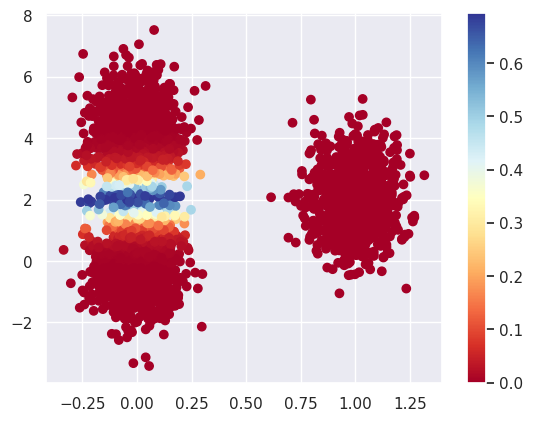

In [46]:
#In this exercise you need to load the dataset used to present K-means ( def km_load_th1() ) or the one used to discuss 
# the Gaussian mixtures model ( def gm_load_th1() ). 
#As discussed, applying a fitting based on gaussian mixtures you can not only predict the cluster label for each point, 
#but also a probability distribution over the clusters. 

#From this probability distribution, you can compute for each point the entropy of the corresponging 
#distribution (using for example scipy.stats.entropy) as an estimation of the undertainty of the prediction. 
#Your task is to plot the data-cloud with a color proportional to the uncertainty of the cluster assignement.

# In detail you shoud:
# 1. Instantiate a GaussianMixture object with the number of clusters that you expect
# 2. fit the object on the dataset with the fit method 

from scipy.stats import entropy
points=gm_load_th1()

plt.figure()
clf = GaussianMixture(n_components=3, covariance_type='full')

clf.fit(points)

# 3. compute the cluster probabilities using the method predict_proba. This will return a matrix of 
# dimension npoints x nclusters
# 4. use the entropy function ( from scipy.stats import entropy ) to evaluate for each point the uncertainty of the 
#prediction

cluster_labels_prob=clf.predict_proba(points)

entropies=[]
for point in range(len(cluster_labels_prob)):
    entropies.append(entropy(cluster_labels_prob[point]))

# 5. Plot the points colored accordingly to their uncertanty. 

cm = plt.cm.get_cmap('RdYlBu')
sc = plt.scatter(points[:,0], points[:,1], c=entropies, cmap=cm)
plt.colorbar(sc)
    

# 3. Dimensionality Reduction

# EXERCISE 1 : Find dimensionality of hidden dataset.

We have  180 samples of dimension  6


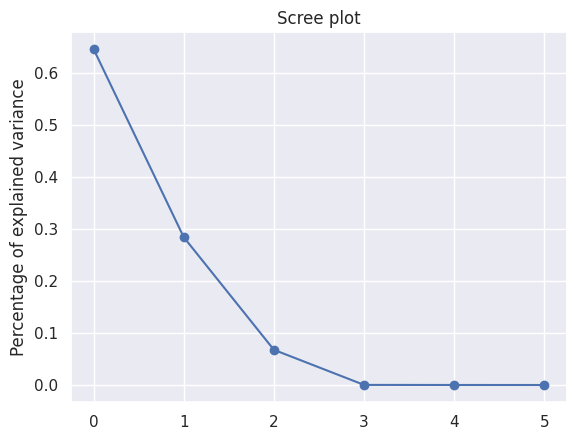

In [47]:
high_dim_dataset=load_multidimensional_data_pca2()
n_samples,n_dim=high_dim_dataset.shape

print('We have ',n_samples, 'samples of dimension ', n_dim)

pca=PCA()
pca.fit(high_dim_dataset)
plt.plot(pca.explained_variance_ratio_,'-o')
plt.title('Scree plot')
plt.ylabel('Percentage of explained variance')
plt.show()

# EXERCISE 3 : Find the dataset shape.

In [48]:
k = 3
scores=pca.transform(high_dim_dataset)
# visualize the `scores.T[:k]` with a scatterplot

x, y, z = scores.T[:k]
fig = px.scatter_3d(x=x, y=y, z=z, )
fig.show()